<a href="https://colab.research.google.com/github/DeekshaChowdhary/Covid_Fake_News_Classification/blob/main/Fake_Newsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
file_path = "/content/drive/MyDrive/Colab Notebooks/fake_news.csv"
data = pd.read_csv(file_path)
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [18]:
data.shape

(20800, 5)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [20]:
data.isna().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [21]:
data = data.drop(['id'], axis =1)

In [22]:
data = data.fillna('')

In [23]:
data['content'] = data['author']+' '+ data['title']+' '+data['text']

In [24]:
data = data.drop(['title','author','text'],axis=1)

In [25]:
data.head()

,label,content
0,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,1,Consortiumnews.com Why the Truth Might Get You...
3,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,1,Howard Portnoy Iranian woman jailed for fictio...


In [26]:
data['content'] = data['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [27]:
data['content'] = data['content'].str.replace('[^\w\s]','')

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
!pip install stopwords

In [30]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [31]:
!pip install textblob

In [32]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
from nltk.stem import WordNetLemmatizer
from textblob import Word
data['content'] = data['content'].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))
data['content'].head()

,content
0,darrell lucus house dem aide: didn’t even see ...
1,"daniel j. flynn flynn: hillary clinton, big wo..."
2,consortiumnews.com truth might get fired truth...
3,jessica purkiss 15 civilian killed single u ai...
4,howard portnoy iranian woman jailed fictional ...


In [34]:
X = data[['content']]
y = data[['label']]

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=45,stratify=y)

In [37]:
print( X_train.shape)
print( y_train.shape)
print( X_test.shape)
print( y_test.shape)

(14560, 1)
(14560, 1)
(6240, 1)
(6240, 1)


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train['content'])
X_train_tfidf = tfidf_vect.transform(X_train['content'])
X_test_tfidf = tfidf_vect.transform(X_test['content'])

In [40]:
from sklearn import metrics

In [41]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
pclf = PassiveAggressiveClassifier()
pclf.fit(X_train_tfidf,y_train)
predictions = pclf.predict(X_test_tfidf)
print(metrics.classification_report(y_test , predictions))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3116
           1       0.96      0.96      0.96      3124

    accuracy                           0.96      6240
   macro avg       0.96      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



In [42]:
print(metrics.confusion_matrix(y_test , predictions))

[[3000  116]
 [ 118 3006]]


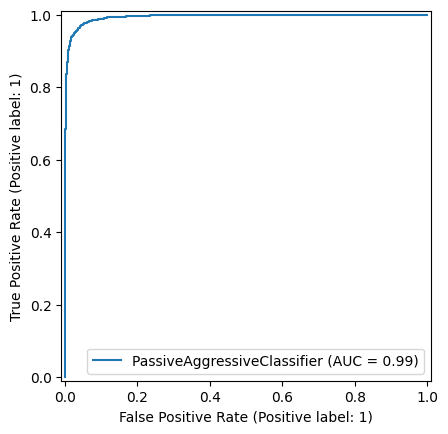

In [43]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(pclf, X_test_tfidf, y_test)
plt.show()

In [44]:
## MLP Classifier
from sklearn.neural_network import MLPClassifier
mlpclf = MLPClassifier(hidden_layer_sizes=(256,64,16),
                       activation='relu',
                       solver='adam')
mlpclf.fit(X_train_tfidf,y_train)
predictions = mlpclf.predict(X_test_tfidf)
print(metrics.classification_report(y_test , predictions))


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3116
           1       0.96      0.96      0.96      3124

    accuracy                           0.96      6240
   macro avg       0.96      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



In [45]:
print(metrics.confusion_matrix(y_test , predictions))

[[3003  113]
 [ 120 3004]]


In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
print(confusion_matrix(y_test, predictions))

[[3003  113]
 [ 120 3004]]


In [51]:
import pickle
pickle.dump(pclf,open('fakenews1.pkl','wb'))

In [52]:
loaded_model = pickle.load(open('fakenews1.pkl','rb'))
result = loaded_model.score(X_test_tfidf,y_test)
print(result)

0.9625
